# Project: Tidal transformation of M33 
# Evolution of the internal stellar structure of M33 


## Disk Profile Movie Maker

In [1]:
# Marco Barragan
# ASTR400B
# 
# This code makes plots for making a movie for the disk Profile
# This code intends to output png files in order to make a movie
# using ffmpeg

In [2]:
# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G
import scipy.optimize as so
import math

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.animation as animation
%matplotlib inline

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile

In [3]:
def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

In [4]:
def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()

    Example Usage
    -------------
     density_contour(x pos, y pos, contour res, contour res, axis, colors for contours)
     e.g.:
     density_contour(xD, yD, 80, 80, ax=ax, colors=['red','orange', 'yellow', 'orange', 'yellow'])

    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))

    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    fmt = {}

    ### Adjust Here #### 

    # Contour Levels Definitions
    #zero_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.50))
    #one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    #two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))

    # You might need to add a few levels
    #one_sigma1 = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.80))
    #one_sigma2 = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.90))

    # Array of Contour levels. Adjust according to the above
    levels = [three_sigma][::-1]    #zero_sigma,one_sigma, one_sigma1, one_sigma2, two_sigma, three_sigma][::-1]

    # contour level labels  Adjust accoding to the above.
    strs = ['0.99'][::-1]    #'0.50','0.68','0.80','0.90','0.95', '0.99'][::-1]


    ###### 

    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        plt.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)

    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        ax.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)

    return contour

In [5]:
# a function that will rotate the position and velocity vectors
# so that the disk angular momentum is aligned with z axis. 

def RotateFrame(posI,velI):
    # input:  3D array of positions and velocities
    # returns: 3D array of rotated positions and velocities such that j is in z direction

    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    # normalize the vector
    L_norm = L/np.sqrt(np.sum(L**2))

    # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)

    # z unit vector
    z_norm = np.array([0, 0, 1])

    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))

    # dot product between L and z 
    c = np.dot(L_norm, z_norm)

    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T

    return pos, vel

In [6]:
# Initialize empty array to append later
avg = np.zeros(801)

In [7]:
# Initialize array of snapshot numbers in terms of time
t = np.arange(0,800.5,1) * 15000 / 1e6 #12Myr / 800 snap = 15000 yr/snap

In [8]:
# Make plots to make a movie
# Loop over each snapshot
# Outputs:
#    List of plots "plot_(snap).png" that are turned into a gif
#    using ffmpeg through the terminal
for i in range(801):
    # Compose the data filename (be careful about the folder)
    # Add a string of the filenumber to "000"
    ilbl = '000' + str(i)
    # Remove all but the last 3 digits
    ilbl = ilbl[-3:]
    filename = "M33_" + ilbl + '.txt'
    
    # Make filename according to Collin's naming scheme for ffpmeg
    outfile = f'plot_{i:03}.png'
    
    # Create a COM of object for M31 Disk Using Code from Assignment 4
    COMD = CenterOfMass(filename,2)

    # Compute COM of M31 using disk particles
    COMP = COMD.COM_P(0.1)
    COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])

    # Initialize COM position and velocity
    # Determine positions of disk particles relative to COM 
    xD = COMD.x - COMP[0].value 
    yD = COMD.y - COMP[1].value 
    zD = COMD.z - COMP[2].value 

    # total magnitude
    rtot = np.sqrt(xD**2 + yD**2 + zD**2)

    # Determine velocities of disk particles relatiev to COM motion
    vxD = COMD.vx - COMV[0].value 
    vyD = COMD.vy - COMV[1].value 
    vzD = COMD.vz - COMV[2].value 

    # total velocity 
    vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)

    # Vectors for r and v 
    r = np.array([xD,yD,zD]).T # transposed 
    v = np.array([vxD,vyD,vzD]).T
    
    # Rotate vectors so that the disk angular momentum is aligned with z axis
    rn, vn = RotateFrame(r,v)
    
    
    # Find the heights----------------------------------------------------------------------------------------
    # Method is similar to the contours. Take standard deviation of the height
    
    # Store an array of rho radii from 0 to maximum
    radius = np.arange(0,10,0.5)

    # Make sure height (z) is always positive 
    dataset = abs(rn[:,2])
    
    # Store the rho radius value of each particle
    rhorad = np.sqrt(rn[:,0]**2 + rn[:,1]**2) 
    
    # Initialize array corresponding to "radius"
    height = np.zeros(len(radius))

    for q in range(len(radius)):
        if(q==len(radius)-1):
            continue
        # Store index filtex for set bin radii
        sec  = np.where((rhorad > radius[q]) & (rhorad < radius[q+1]))
            
        # Store value of 3 standard deviations of height of the particles
        stdev   = np.where(dataset[sec] < np.std(dataset[sec])) 
        
        height[q] = np.mean(dataset[sec][stdev])
    
    # Store the average of the heights within 1 stdev
    avg[i] = np.mean(height)
    
    # Store value of the max height value
    maximum = height.max()
    # Some values became NaN, so here is a precaution
    if(math.isnan(maximum)==True or maximum==float('inf')):
            maximum = 3
            
    
    # Make plots and save them -------------------------------------------------------------------------------
    fig, axs = plt.subplots(2, 2)
    # plot the particle density for M33 
    # can modify bin number (bin =100 smoothest)
    axs[0,0].hist2d(rn[:,0], rn[:,1], bins=150, norm=LogNorm(), cmap='magma')

    # make the contour plot
    # x pos, y pos, contour res, contour res, axis, colors for contours.
    density_contour(rn[:,0], rn[:,1], 80, 80, ax=axs[0,0], colors=['red']) #,'white', 'white', 'white', 'white'])
    
    axs[0, 0].set_title("Face On")
    axs[0, 0].set_xlabel("x (kpc)")
    axs[0, 0].set_ylabel("y (kpc)")

    # Rotated M31 Disk - EDGE ON

    # plot the particle density for M33 (x,z)
    # can modify bin number (bin =100 smoothest)
    axs[0, 1].hist2d(rn[:,0], rn[:,2], bins=150, norm=LogNorm(), cmap='magma')
    density_contour(rn[:,0], rn[:,2], 80, 80, ax=axs[0,1], colors=['red']) #,'white', 'white', 'white', 'white'])
    
    axs[0, 1].set_title("Edge On")
    axs[0, 1].set_xlabel("x (kpc)")
    axs[0, 1].set_ylabel("z (kpc)")
    
    # plot the particle density for M33 (y,z)
    # can modify bin number (bin =100 smoothest)
    axs[1, 0].hist2d(rn[:,1], rn[:,2], bins=150, norm=LogNorm(), cmap='magma')
    density_contour(rn[:,1], rn[:,2], 80, 80, ax=axs[1,0], colors=['red']) #,'white', 'white', 'white', 'white'])
    
    axs[1, 0].set_title("Edge On")
    axs[1, 0].set_xlabel("y (kpc)")
    axs[1, 0].set_ylabel("z (kpc)")

       
    # plot the 3 stdev height of the particles of M33's disk
    # can modify bin number (bin =100 smoothest)
    axs[1, 1].plot(radius, height)
    
    axs[1, 1].set_title("Thickness")
    axs[1, 1].set_xlabel("Radius (kpc)")
    axs[1, 1].set_ylabel("Approximate Height (kpc)")
    
    axs[1, 1].set_ylim(0,np.around(maximum*1.3,2))
    
    axs[1,1].text(.24,np.around(maximum,2),"Snapshot " + str(i))
    
    # Axis number fonts changed arbitrarily, so here they are fixed
    axs[0,0].tick_params(axis='both', which='major', labelsize=8)
    axs[0,1].tick_params(axis='both', which='major', labelsize=8)
    axs[1,0].tick_params(axis='both', which='major', labelsize=8)
    axs[1,1].tick_params(axis='both', which='major', labelsize=8)
    
    # Make sure all labels and plots are visible with no clutter
    plt.tight_layout()
    
    # Save and close file
    plt.savefig(outfile)
    plt.close()
    
    # Print Snap number for progress
    print(i)
    
    '''fig = plt.figure()
    DPI = fig.get_dpi()
    fig.set_size_inches(1200/float(DPI),610.0/float(DPI))'''

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


659
660
661


C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717


C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


718
719
720
721


C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


722
723


C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


724
725


C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


726
727
728


C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


729
730
731
732
733
734
735
736
737


C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


738
739


C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


740
741
742
743
744
745


C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


746
747


C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


748
749
750
751


C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\XNAZ1\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800


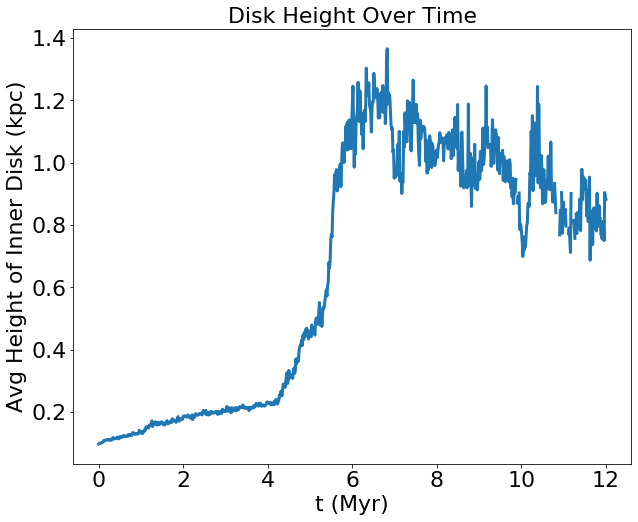

In [11]:
# Plot the Average Height of the Inner Disk Over Time
#################################
fig,ax = plt.subplots(figsize=(10,8))

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Plot 
plt.plot(t, avg, linewidth=3)

# Axes labels 
plt.title('Disk Height Over Time',fontsize=22)
plt.xlabel('t (Myr)',fontsize=22) 
plt.ylabel('Avg Height of Inner Disk (kpc)', fontsize=22)

plt.savefig("DiskTime.png")

In [13]:
# Initialize array of snapshot numbers
snap = np.arange(0,800.5,1)

Text(0, 0.5, 'Avg Height of Inner Disk (kpc)')

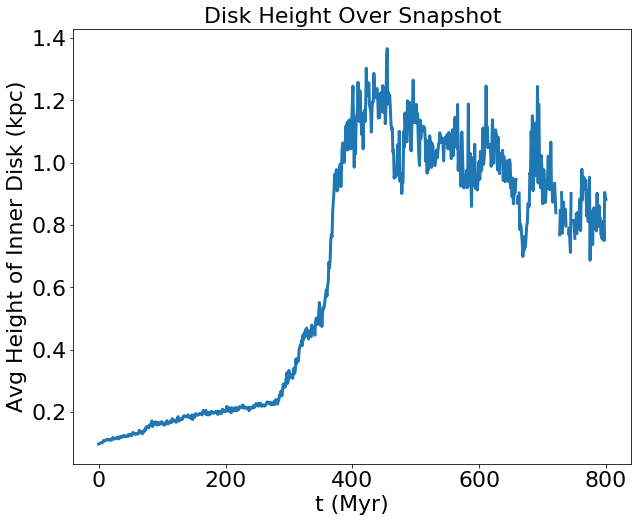

In [21]:
# Plot the Average Height of the Inner Disk Over Snapshots
# Used to see what snapshots to use for the paper
#################################
fig,ax = plt.subplots(figsize=(10,8))

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Plot 
plt.plot(snap, avg, linewidth=3)

# Axes labels 
plt.title('Disk Height Over Snapshot',fontsize=22)
plt.xlabel('t (Myr)',fontsize=22) 
plt.ylabel('Avg Height of Inner Disk (kpc)', fontsize=22)